In [1]:
#!pip install torch torchvision numpy matplotlib Pillow opencv-python
# import sys
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

Necessary imports and helper functions for displaying points, boxes, and masks.

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: mps


In [4]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    # if borders:
    #     import cv2
    #     contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    #     # Try to smooth contours
    #     contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
    #     mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        # if box_coords is not None:
        #     # boxes
        #     show_box(box_coords, plt.gca())
        # if len(scores) > 1:
        #     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

## Example image

In [5]:
image = Image.open('/Users/rgoomer/Documents/Freelance/Guidance_Labs/SAM2_Gcode/sample_image/IMG_2861.JPG')
image = np.array(image.convert("RGB"))

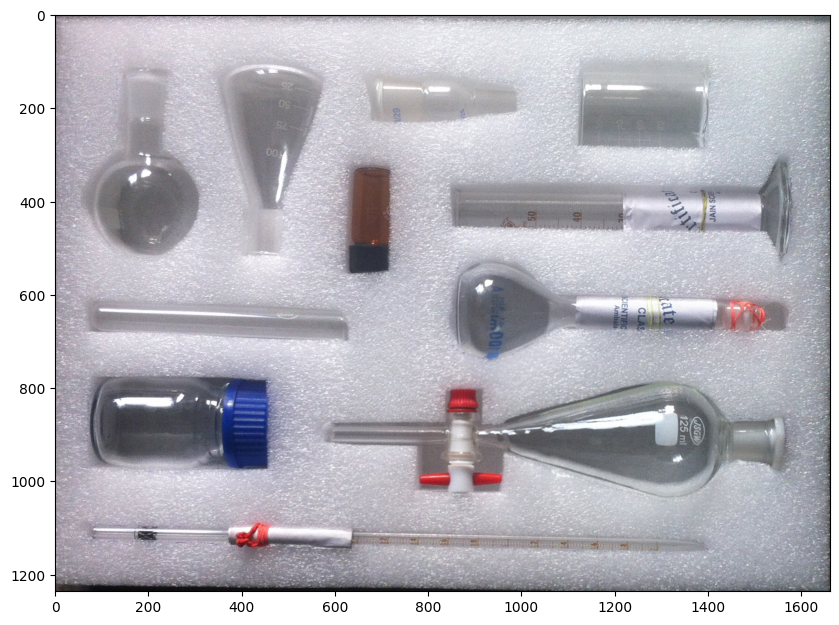

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM 2

First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.

In [7]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [8]:
predictor.set_image(image)

/opt/anaconda3/envs/guidance/lib/python3.10/site-packages/torch/nn/functional.py:4095: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(input, output_size, align_corners, scale_factors)


In [9]:
# For object 1 (3 points)
object1_pts = np.array([[50,50],[450, 300], [450, 450]]) ##col,row
object1_labels = np.array([0,1, 1])

# For object 2 (4 points)
object2_pts = np.array([[50,50],[1000, 400], [1400, 400], [1200, 400], [1550, 500]])
object2_labels = np.array([0,1, 1, 1,1])

# For object 3 (3 points)
object3_pts = np.array([[50,50],[750, 200], [900, 200]])
object3_labels = np.array([0,1, 1])

# For object 4 (3 points)
object4_pts = np.array([[50,50],[200, 200], [200, 400]])
object4_labels = np.array([0,1, 1])

# Combine into lists
all_pts = [object1_pts, object2_pts, object3_pts, object4_pts]
all_labels = [object1_labels, object2_labels, object3_labels, object4_labels]


In [10]:
# Initialize combined_masks (assuming you want to start with an empty array)
combined_masks = np.empty((0, *image.shape[:2]), dtype=np.float32)  # Adjust shape_of_single_mask as needed

for obj in range(len(all_pts)):
    mask, scores, logits = predictor.predict(
                                point_coords=all_pts[obj],
                                point_labels=all_labels[obj],
                                multimask_output=False )
    combined_masks = np.concatenate([combined_masks,mask], axis=0)
    

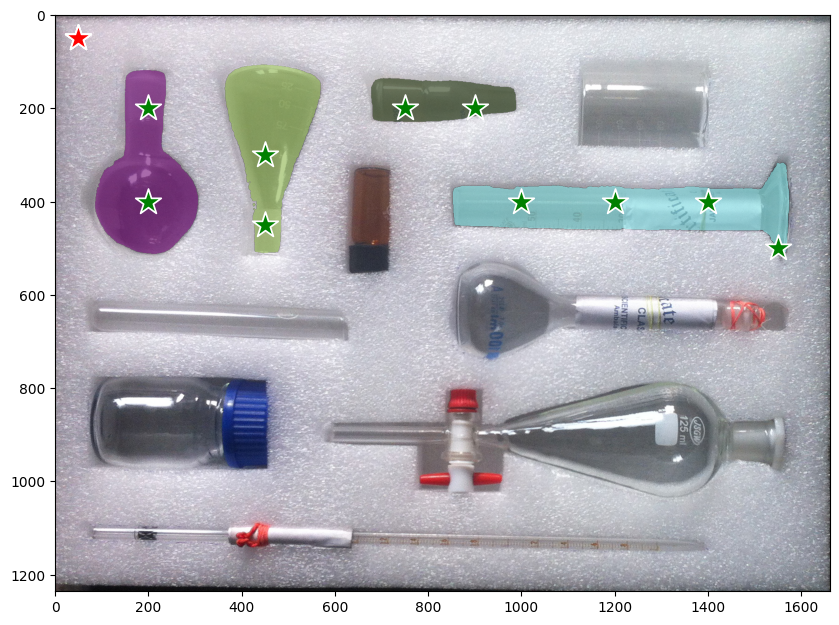

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image)   
for mask in range(len(combined_masks)):
    show_mask(combined_masks[mask], plt.gca(), random_color=True)
    show_points(all_pts[mask], all_labels[mask], plt.gca())

In [12]:
import cv2

added_mask = np.sum(combined_masks, axis=0)

smooth_mask = cv2.morphologyEx(added_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)))

contours, _ = cv2.findContours(smooth_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours
min_contour_area = 500  # Adjust this value based on your needs
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

output = smooth_mask.copy()

approx_contours = []
for contour in filtered_contours:
    epsilon_val = 0.005 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon_val, True)
    cv2.drawContours(output, [approx], -1, (255, 255, 255), 5)
    approx_contours.append(approx)

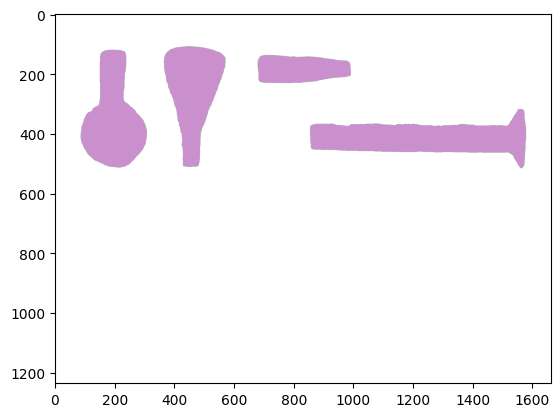

In [13]:
show_mask(smooth_mask, plt.gca(), random_color=True)

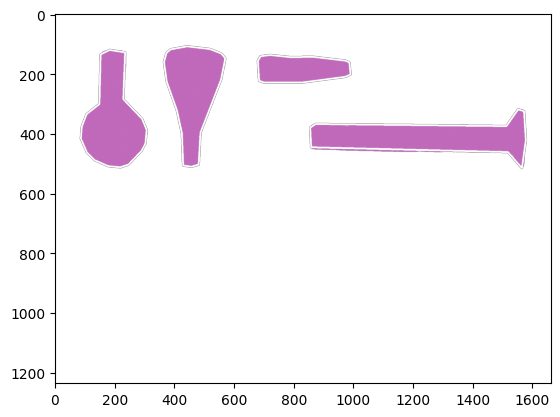

In [14]:
show_mask(output, plt.gca(), random_color=True)